<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>CS 234 - Fall 2022 - Linear-Time Construction of Suffix Trees</h1></center>
<center><h1>Due: Sunday, December 4th, 2022</h1></center>

### Enter your information below:

<div style="color: #000000;background-color: #EEEEFF">
    Your Name (submitter): Jiajun Yu <br>
    Your student ID (submitter): 862325139
<br>
<br>
<b>By submitting this notebook, I assert that the work below is my own work, completed for this course.  Except where explicitly cited, none of the portions of this notebook are duplicated from anyone else's work or my own previous work.</b>
<br>    
<br>
<B>Late work:</B> There is no late deadline for the final project, except for the most serious circumstances (illness, medical emergency, etc.) which have to be documented.
</div>


<hr style="height:5px;border-width:2;color:gray;background-color:#000000"> 
<center><h1>Ukkonen's algorithm</h1></center>
<br>
In this project you will implement the construction of suffix trees in linear-time using Ukkonen's algorithm. This algorithm was <B>not</B> explained in class. Part of this project is to understand how the algorithm works before starting the implementation. Here is some resources:
<UL>
    <li><A HREF="https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwijjZ-oso_3AhWiIUQIHetGA1IQFnoECAMQAQ&url=http%3A%2F%2Fresearch.engineering.nyu.edu%2F~greg%2Falgo2%2Fprojects%2FSuffix_Tree_Implementation.pdf&usg=AOvVaw0Dqiem0l4NxXi41DvXUQ3N">Gusfield's chapter on suffix trees</A> from his <A HREF="https://www.amazon.com/dp/0521585198">book</A></li>
    <li><A HREF="https://www.geeksforgeeks.org/ukkonens-suffix-tree-construction-part-1/">GeeksforGeeks</A></li>
    <li><A HREF="https://brenden.github.io/ukkonen-animation/">Ukkonen's animation</A>, step by step</li>
    <li><A HREF="https://stackoverflow.com/questions/9452701/ukkonens-suffix-tree-algorithm-in-plain-english">StackOverflow</A></li>
    <li>There are several videos on YouTube, e.g., <A HREF="https://www.youtube.com/watch?v=aPRqocoBsFQ">this one</A></li>
    <li>Use <A HREF="https://www.google.com/search?q=ukkonen+algorithm">Google</A> for more</li>
</UL>

Goals:
<UL>
    <LI>Write a working (bug-free) Python3 implementation of Ukkonen's algorithm in JupyterHub that runs in linear time</LI>
    <LI>Make sure that your implementation is correct: compare the output of your implementation to the output for the O(n^2) implementation that we used in Homework 2</LI>
    <LI>Collect experimental results on running your code for larger and larger inputs, say 1000, 2000, 5000, 10000, 100000 symbols, and plot the running time as a function of the input size</LI>
</UL>

You are allowed to study C/C++ implementations of Ukkonen's algorithm, but you have to write your own Python code. It is mandatory to acknowledge sources.


In [7]:
# YOUR CODE HERE
# no suffix tree libraries allowed
# refer to https://www.cnblogs.com/xubenben/p/3486007.html
from abc import abstractmethod
from typing import List, Dict
import math
INF = math.inf

class Tree:
    class TreeNode:
        def __init__(self, tree, interv: List[int], leaf: bool = False):
            self.leaf = leaf  # whether is a leaf
            self.tree: Tree = tree
            self.interval = interv  # the node represents substring s[l, r]
            self.link = None  # suffix link
            self.children: Dict[str, Tree.TreeNode] = {}
            self.idx = -1  # if it is a leaf, we will change this

        def get_text(self) -> str:
            return self.tree.text[self.interval[0]:min(self.interval[1] + 1, self.tree.pos)]

        def add_child(self, char: str, node):
            self.children[char] = node
            self.leaf = False

        def match(self, pattern: str, result: List[int]):
            text = self.get_text()
            if pattern == '' or text.startswith(pattern):
                if self.leaf:
                    result.append(self.idx)
                    return True
                else:
                    # dfs
                    for key, child in self.children.items():
                        child.match('', result)
                    return True

            if not self.leaf and pattern.startswith(text):
                pattern = pattern[len(text):]
                for key, child in self.children.items():
                    if pattern[0] == key:
                        child.match(pattern, result)

        def suffix_link(self, node):
            self.link = node

        def __str__(self):
            if self.leaf:
                return '[{0}: {1}]'.format(self.get_text(), self.idx)
            else:
                return '({})'.format(self.get_text())

        def edge_len(self) -> int:
            return min(self.interval[1], self.tree.pos) - self.interval[0] + 1

    def __init__(self):
        self.root = Tree.TreeNode(self, [-1, -1])
        self.cur_node = self.root  # current node
        self.text: str = ''  # corresponding text
        self.pos: int = -1  # current position in the text
        self.link_from = None  # node that need a suffix link
        self.leaves_needed: int = 0  # number of leaves to be added
        self.cur_char: int = 0
        self.cur_radius: int = 0
        self.created = False

    @abstractmethod
    def extend(self, char: str):
        pass

    def setSuffixIndex(self, node: TreeNode, labelHeight: int):
        if not node:
            return
        if node.leaf:
            node.idx = len(self.text) - labelHeight
            return
        for key, child in node.children.items():
            self.setSuffixIndex(child, labelHeight + child.edge_len())

    @abstractmethod
    def create(self, text: str):
        pass

    def match(self, pattern: str):
        if not self.created:
            print('The tree is still empty!')
            return []
        result = []
        self.root.match(pattern, result)
        return result

In [8]:
class LinearTree(Tree):
    def __init__(self):
        super().__init__()
        self.root = LinearTree.TreeNode(self, [-1, -1], True)
        self.cur_node = self.root

    def add_suffix_link(self, node: Tree.TreeNode):
        if type(self.link_from) == LinearTree.TreeNode:
            self.link_from.suffix_link(node)
        self.link_from = node

    def to_next_layer(self, node: Tree.TreeNode):
        self.cur_char += node.edge_len()
        self.cur_radius -= node.edge_len()
        self.cur_node = node

    def create(self, text: str):
        text += '$'
        for c in text:
            self.extend(c)
        self.setSuffixIndex(self.root, 0)
        self.created = True

    def extend(self, char: str):
        self.text: str = ''.join([self.text, char])
        self.pos += 1
        self.leaves_needed += 1
        lastNewNode = None
        while self.leaves_needed:
            if not self.cur_radius:
                self.cur_char = self.pos
            if self.text[self.cur_char] not in self.cur_node.children.keys():
                # create a leaf node
                leaf = LinearTree.TreeNode(self, [self.pos, INF], True)
                self.cur_node.add_child(self.text[self.cur_char], leaf)
                # self.cur_node.children[self.text[self.cur_char]] = leaf
                if lastNewNode:
                    lastNewNode.suffix_link(self.cur_node)
                    lastNewNode = None
            else:
                next_node: LinearTree.TreeNode = self.cur_node.children[self.text[self.cur_char]]
                if self.cur_radius >= next_node.edge_len():
                    self.to_next_layer(next_node)
                    continue
                if self.text[next_node.interval[0] + self.cur_radius] == char:
                    self.cur_radius += 1
                    if lastNewNode and self.cur_node != self.root:
                        lastNewNode.suffix_link(self.cur_node)
                        lastNewNode = None
                    break
                # create branch node
                branch = LinearTree.TreeNode(self, [next_node.interval[0], next_node.interval[0] + self.cur_radius - 1])
                self.cur_node.add_child(self.text[self.cur_char], branch)
                # add a leaf
                leaf = LinearTree.TreeNode(self, [self.pos, INF], True)
                branch.add_child(char, leaf)
                next_node.interval[0] += self.cur_radius
                # add branches to the branch node
                branch.add_child(self.text[next_node.interval[0]], next_node)
                if lastNewNode:
                    lastNewNode.suffix_link(branch)
                lastNewNode = branch
            self.leaves_needed -= 1

            if self.cur_node == self.root and self.cur_radius:
                self.cur_radius -= 1
                self.cur_char = self.pos - self.leaves_needed + 1
            else:
                self.cur_node = self.cur_node.link if self.cur_node.link else self.root

In [9]:
class QuadraticTree(Tree):
    def __init__(self, text):
        super().__init__()
        self.root = QuadraticTree.TreeNode(self, [-1, -1], True)
        # self.cur_node = self.root
        self.text = text + '$'
        self.pos = len(self.text)
        self.create(self.text)

    def extend(self, s: str):
        # TODO: add '$' to the text
        idx = len(self.text) - len(s)
        ss = s
        cur_node = self.root
        while len(s) > 0:
            if s[0] not in cur_node.children:
                child = QuadraticTree.TreeNode(self, [len(self.text)-len(s), len(self.text)-1], True)
                # child.idx = idx
                cur_node.add_child(s[0], child)
                return
            child = cur_node.children[s[0]]
            text = child.get_text()
            if len(s) > len(text) and s.startswith(text):
                s = s[len(text):]
                cur_node = child
                continue
            i = 0
            while i < len(s) and text[i] == s[i]:
                i += 1
            # from i to the end
            leaf = QuadraticTree.TreeNode(self, [len(self.text) - len(s) + i, len(self.text) - 1], True)
            # leaf.idx = child.interval[0] + i
            # from 0 to i-1
            branch = QuadraticTree.TreeNode(self, [child.interval[0], child.interval[0] + i - 1])
            # from i to the end of the original child node
            child.interval[0] += i
            # child.idx = idx
            cur_node.add_child(s[0], branch)
            branch.add_child(self.text[child.interval[0]], child)
            branch.add_child(self.text[leaf.interval[0]], leaf)
            break

    def create(self, text: str):
        for i in range(len(text)):
            self.extend(text[i:])
        self.setSuffixIndex(self.root, 0)
        self.created = True

In [10]:
# test whether both trees can perform correctly
# string = 'ATCGTCAG'
string = 'mississippi'
patterns = ['mis', 'ssi', 'sssi']
lt = LinearTree()
lt.create(string)
qt = QuadraticTree(string)

for pat in patterns:
    res_lt = lt.match(pat)
    res_lt.sort()
    print(res_lt)
    res_qt = qt.match(pat)
    res_qt.sort()
    print(res_qt)

[0]
[0]
[2, 5]
[2, 5]
[]
[]


In [13]:
import random
import time

# use random cases to test the running time

alphabet = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
# alphabet = 'ATCG'

def rand_str(len_str, alphabet_lib) -> str:
    n = len(alphabet_lib)
    s = ''
    for _ in range(len_str):
        s += str(random.randint(0, n))
    return s

sizes = [1000, 2000, 5000, 10000, 100000, 500000]
time_lt = []
time_qt = []
pattern_size = [10, 20, 50, 100, 200]
for i, size in enumerate(sizes):
    s = rand_str(size, alphabet)
    time1 = 0
    for j in range(5):
        start_lt_time = time.time()
        lt = LinearTree()
        lt.create(s)
        end_lt_time = time.time()
        time1 += end_lt_time - start_lt_time
    time2 = 0
    for j in range(5):
        start_qt_time = time.time()
        qt = QuadraticTree(s)
        end_qt_time = time.time()
        time2 += end_qt_time - start_qt_time
    time1 /= 5
    time2 /= 5
    time_lt.append(time1)
    time_qt.append(time2)
    print('Construction time: linear tree {0}s vs '
          'quadratic tree {1}s'.format(time1, time2))
    for pat_size in pattern_size:
        pat = rand_str(pat_size, alphabet)
        lt_match = lt.match(pat)
        lt_match.sort()
        qt_match = qt.match(pat)
        qt_match.sort()
        if lt_match != qt_match:
            print('Different results for pattern {}'.format(pat))
            break
    else:
        print('Results of the two trees are the same')

Construction time: linear tree 0.026398658752441406s vs quadratic tree 0.017399930953979494s
Results of the two trees are the same
Construction time: linear tree 0.07552900314331054s vs quadratic tree 0.036797952651977536s
Results of the two trees are the same
Construction time: linear tree 0.656885290145874s vs quadratic tree 0.23536877632141112s
Results of the two trees are the same
Construction time: linear tree 0.5176337242126465s vs quadratic tree 0.5062103271484375s
Results of the two trees are the same
Construction time: linear tree 6.000340747833252s vs quadratic tree 10.564887285232544s
Results of the two trees are the same


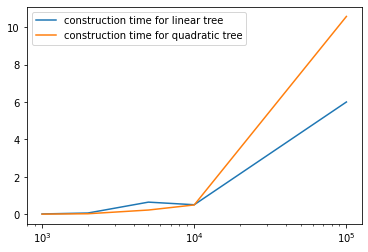

In [14]:
# plot
import matplotlib.pyplot as plt
plt.plot(sizes, time_lt, label='construction time for linear tree')
plt.plot(sizes, time_qt, label='construction time for quadratic tree')
plt.xscale('log')
plt.legend()
plt.savefig('time_comparison.jpg')
plt.show()
